In [1]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter


# Set seaborn styles for the plots
sns.set_style('whitegrid')
sns.set_context("paper")

In [2]:
# Read data from pickle file
dfx = pd.read_pickle('./data/sym_asy_indices.pkl', compression = 'gzip')

# Extract dates with ASY-H index values above or equal to the low threshold
dates_asy = dfx['ASY_H'].reset_index().copy()
dates_asy = dates_asy.loc[dates_asy['ASY_H'] >= utils.ASY_H_THRESHOLD_LOW]

# Set the last valid year for storm classification
last_valid_year = 2022

# Initialize empty list to store storm data
storms_asy = []

In [3]:
# Iterate over dates with ASY-H index values above the low intensity threshold
for i in range(len(dates_asy)):
    st = dates_asy.iloc[i]['datetime'] - utils.MINIMUM_DAYS_BEFORE
    nd = dates_asy.iloc[i]['datetime'] + utils.MINIMUM_DAYS_AFTER
    
    # Find the last and first values over the low threshold within a minimum offset of one day before and after
    last_low_value = dfx[st:nd].loc[dfx[st:nd]['ASY_H'] >= utils.ASY_H_THRESHOLD_LOW].last_valid_index()
    first_low_value = dfx[st:nd].loc[dfx[st:nd]['ASY_H'] >= utils.ASY_H_THRESHOLD_LOW].first_valid_index()
    
    # Adjust the start and end dates of the storm period determined with the superposed epoch analysis
    newst = first_low_value - utils.STORM_DAYS_BEFORE_OFFSET
    newst = newst.floor('D')
    newnd = last_low_value + utils.STORM_DAYS_AFTER_OFFSET
    newnd = newnd.ceil('D')
    
    # If the end year exceeds the last valid year, continue to the next date
    if (newnd.year > last_valid_year):
        continue
    
    # Create a new DataFrame to store the storm data within the adjusted storm period
    new_df = dfx[newst:newnd].copy()
    
    # Extend the storm period if there are additional last low values beyond the initial range
    while dfx[newst:newnd].loc[dfx[newst:newnd]['ASY_H'] >= utils.ASY_H_THRESHOLD_LOW].last_valid_index() > last_low_value:
        last_low_value = dfx[newst:newnd].loc[dfx[newst:newnd]['ASY_H'] >= utils.ASY_H_THRESHOLD_LOW].last_valid_index()
        newnd = last_low_value + utils.STORM_DAYS_AFTER_OFFSET
        newnd = newnd.ceil('D')
        new_df = dfx[newst:newnd].copy()        
    
    # Check if there is already a storm in the list and its end date is greater than or equal to the adjusted start date
    if (len(storms_asy) >= 1):
        if storms_asy[-1].index[-1] >= newst:
            # Concatenate the new storm data with the previous storm data
            new_df = pd.concat([storms_asy[-1], new_df])            
            new_df = new_df[~new_df.index.duplicated(keep='first')]
            storms_asy[-1] = new_df            
            continue
    
    # Append the new storm data to the list
    storms_asy.append(new_df)
    
# Print the total number of storms
print(f"Total storms: {len(storms_asy)}")

Total storms: 284


In [4]:
# Create a summary dataframe with the start and end dates, the duration, the maximum ASY-H value 
# of the storm and the corresponding class of the storm
summary_df_asy = utils.get_summary_df_asy(storms_asy)
summary_df_asy['classification'] = 'LOW'
summary_df_asy.loc[(summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_MODERATE) & (summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_INTENSE), 'classification'] = 'MODERATE'
summary_df_asy.loc[(summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_INTENSE) & (summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_SUPERINTENSE), 'classification'] = 'INTENSE'
summary_df_asy.loc[summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_SUPERINTENSE, 'classification'] = 'SUPERINTENSE'

In [6]:
# Get the indices of storms classified as 'LOW'
low_indices = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_LOW ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_MODERATE ))].index

# Get the indices of storms classified as 'MODERATE'
moderate_indices = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_MODERATE ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_INTENSE ))].index

# Get the indices of storms classified as 'INTENSE'
intense_indices  = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_INTENSE ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_SUPERINTENSE ))].index

# Get the indices of storms classified as 'SUPERINTENSE'
superintense_indices  = summary_df_asy.loc[summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_SUPERINTENSE].index

Maximum ASY-H value 176 at: 1990-11-27 17:10:00


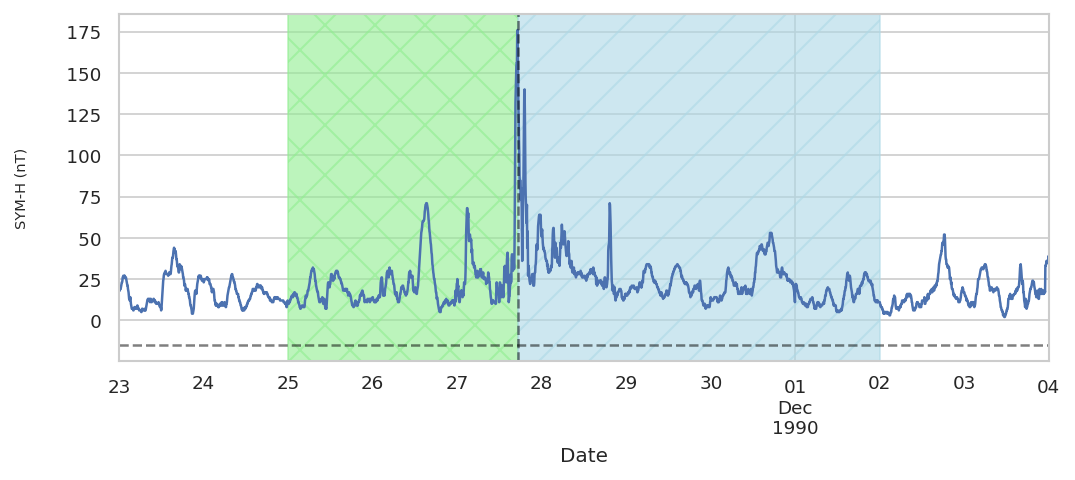

Maximum ASY-H value 516 at: 1991-06-05 17:00:00


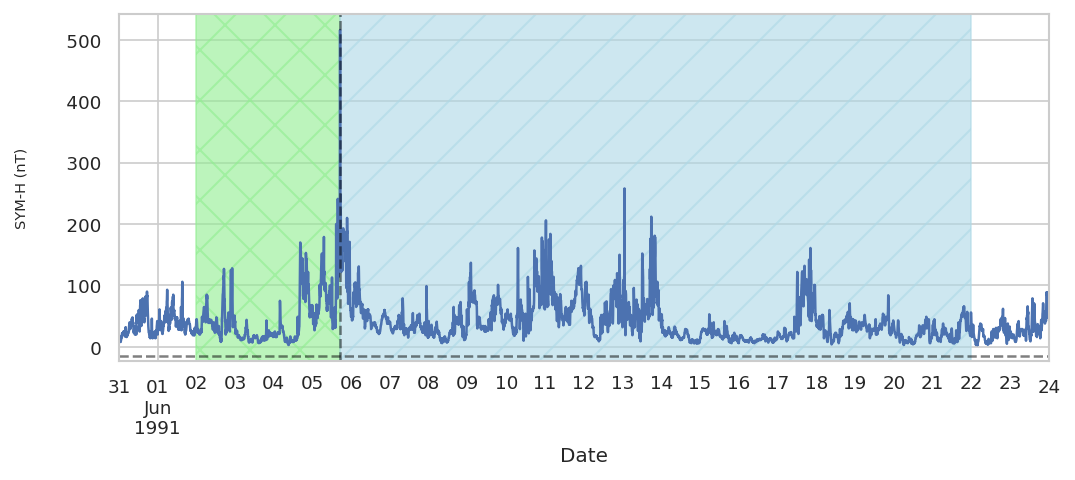

Maximum ASY-H value 223 at: 1990-05-26 22:05:00


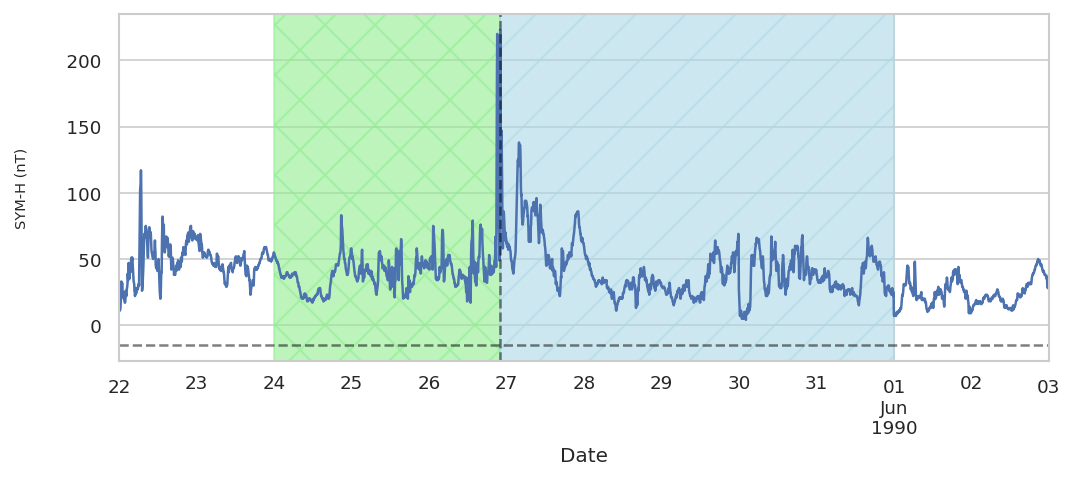

Maximum ASY-H value 147 at: 1993-03-15 11:35:00


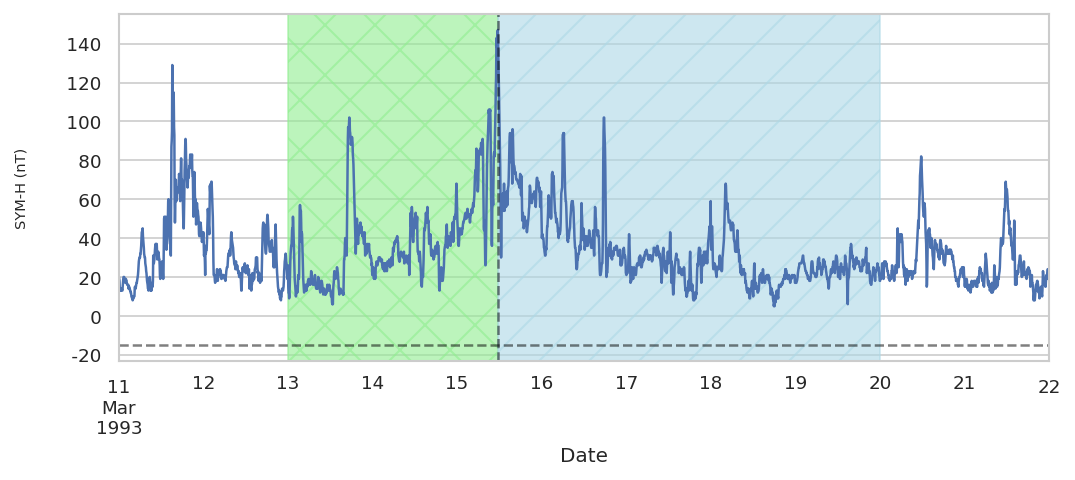

Maximum ASY-H value 250 at: 2005-05-15 08:45:00


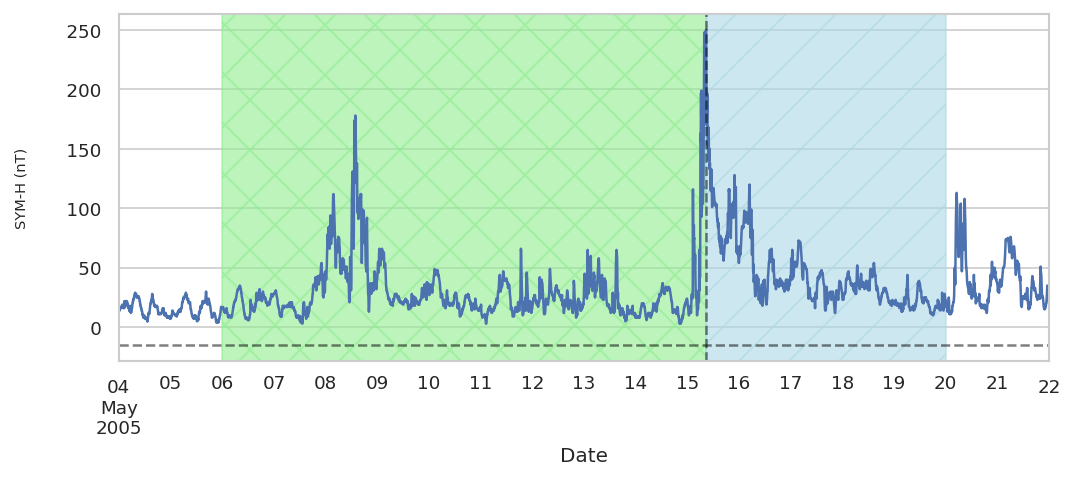

Maximum ASY-H value 130 at: 2006-07-28 03:10:00


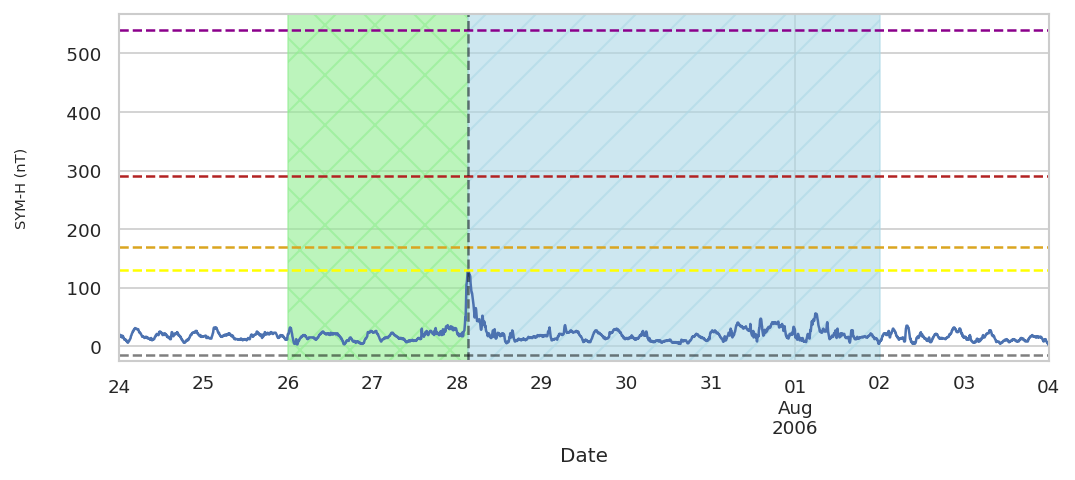

In [7]:
inds = [80, 82, 74, 99, 210, 218]

for ind in inds:
    #ax = utils.plot_storm_asy(dfx, summary_df_asy, ind)
    strm = utils.get_storm(dfx, summary_df_asy, ind)
    strm_start = strm.index[0]
    strm_end = strm.index[-1]
    idxmax = strm['ASY_H'].idxmax()

    offset = pd.DateOffset(days = 2)

    strm_full = dfx[strm_start - offset : strm_end + offset]

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 3))

    # Plot the SYM-H values for the specified storm period
    strm_full["ASY_H"].plot(legend=False, xlabel="Date", ax=ax)

    # Set the y-axis label
    ax.set_ylabel("SYM-H (nT)", fontsize=7)

    # Add horizontal lines to represent different SYM-H thresholds for storm intensity levels
    max_asy = strm_full["ASY_H"].max()
    if max_asy <= utils.ASY_H_THRESHOLD_LOW:
        ax.axhline(utils.ASY_H_THRESHOLD_LOW, linestyle="--", color=utils.COLOR_LOW)

        if max_asy <= utils.ASY_H_THRESHOLD_MODERATE:
            ax.axhline(utils.ASY_H_THRESHOLD_MODERATE, linestyle="--", color=utils.COLOR_MODERATE)

            if max_asy <= utils.ASY_H_THRESHOLD_INTENSE:
                ax.axhline(utils.ASY_H_THRESHOLD_INTENSE, linestyle="--", color=utils.COLOR_INTENSE)

                if max_asy <= utils.ASY_H_THRESHOLD_SUPERINTENSE:
                    ax.axhline(
                        utils.ASY_H_THRESHOLD_SUPERINTENSE, linestyle="--", color=utils.COLOR_SUPERINTENSE
                    )

    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:>8.0f}"))

    #ax.fill_between(strm.index, strm_full['ASY_H'].max(), strm_full['ASY_H'].max(),
    #                interpolate=True, color=utils.COLOR_SUPERINTENSE, alpha = 0.6, hatch='x')

    ax.axvspan(strm.index[0], idxmax, color = 'lightgreen', alpha = 0.6, hatch='x')
    ax.axvspan(idxmax, strm.index[-1], color = 'lightblue', alpha = 0.6, hatch='/')


    ax.axvline(strm['ASY_H'].idxmax(), linestyle = '--', color = 'black', alpha = 0.5)
    ax.axhline(-15, linestyle = '--', color = 'black', alpha = 0.5)
    print(f'Maximum ASY-H value {strm_full["ASY_H"].max()} at: {strm_full["ASY_H"].idxmax()}')
    plt.savefig(f'figs/asy-storm-{ind}.png')
    plt.show();